# Lab 05: Motion correction and slice timing

The purpose of this lab is to practice correcting for volume-to-volume motion in a functional image series, and to learn about common correction parameters and how to describe them with numbers and figures. We will also practice slice-timing correction, and test its effect on the timeseries data. 

## Preparation
* Import python tools for plotting
* Copy functional image from lab 01 into our working directory

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import plotting
from nilearn import image

In [3]:
%%bash

cp ../01-Lab/osfshare/sub-97_task-flanker_bold.nii.gz my_bold.nii.gz

## Describing and detecting motion with FSL tools

FSL offers a tool to detect motion outliers and to visually inspect motion and related changes in BOLD signal intensity
* [FSL Motion Outliers](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSLMotionOutliers)
* This will create a dummy variable that codes for volumes possibly corrupted by motion, which can be used to ignore those volumes in our functional image analysis later. 

In [4]:
%%bash

# Running the bare bones command like below will output only the confound matrix 
# The default metric for detecting outliers is refrms (root mean square intensity diffs with referece vol, which is middle volume)
fsl_motion_outliers -i my_bold.nii.gz -o my_bold_motion 

In [1]:
%%bash

# What do the columns represent?
cat my_bold_motion

0   0   0   0   0   0   0   0   0   0   0   0  
1   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   

In [14]:
%%bash

# We can produce figures of the motion by adding the -p flag
# What is refrms?
fsl_motion_outliers -i my_bold.nii.gz -o my_bold_motion -s refrms_ts -p refrms_plot

![refrms](refrms_plot.png)

In [9]:
%%bash

# This version of the command will use dvars as the metric for detecting outliers
# DVARS: temporal Derivatives, VARS refers to root mean square of variance of global signal timecourse
fsl_motion_outliers -i my_bold.nii.gz -o my_bold_motion --dvars -s dvars_ts -p dvars_plot

![dvars](dvars_plot.png)

In [13]:
%%bash

# This version of the command will use fd as the metric for detecting outliers
# FD stands for: 
fsl_motion_outliers -i my_bold.nii.gz -o my_bold_motion --fd -s fd_ts -p fd_plot

![fd](fd_plot.png)

### Questions:
* What are the similarities and differences of the refrms and dvars metrics?
    * Similarities:
    * Differences: 
* How does FD differ from both refrms and dvars?
    * Which metric is "closest to the data" with respect to describing the effects of motion?

### Descriptive statistics on motion metrics

In [12]:
dvars=pd.read_table('dvars_ts',header=None)

In [13]:
# Preview first 5 values in timeseries
dvars.head()

,0
0,0.0000
1,38.0018
2,23.1617
3,23.4676
4,19.2310


In [14]:
# Descriptives
dvars.describe()

,0
count,315.000000
mean,22.405915
std,5.424755
min,0.000000
25%,20.086100
50%,21.482400
75%,22.951800
max,66.238100


In [15]:
dvars.mean()

0    22.405915
dtype: float64

### Practice: what is the mean fd ?

In [9]:
# Python code


## Motion correction tools in FSL

mcflirt is the basic motion correction tool provided by FSL
* [User guide](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MCFLIRT)

In [46]:
%%bash

# Look at usage for mcflirt
mcflirt

Usage: mcflirt -in <infile> [options]

  Available options are:
        -out, -o <outfile>               (default is infile_mcf)
        -cost {mutualinfo,woods,corratio,normcorr,normmi,leastsquares}        (default is normcorr)
        -bins <number of histogram bins>   (default is 256)
        -dof  <number of transform dofs>   (default is 6)
        -refvol <number of reference volume> (default is no_vols/2)- registers to (n+1)th volume in series
        -reffile, -r <filename>            use a separate 3d image file as the target for registration (overrides refvol option)
        -scaling <num>                             (6.0 is default)
        -smooth <num>                      (1.0 is default - controls smoothing in cost function)
        -rotation <num>                    specify scaling factor for rotation optimization tolerances
        -verbose <num>                     (0 is least and default)
        -stages <number of search levels>  (default is 3 - specify 4 for final s

In [10]:
%%bash

# Example mcflirt call with defaults
# Input does not have to be skull stripped
# Default cost function is normalized correlation
# Why is the refvol 157?

mcflirt -in my_bold \
-out my_bold_mcf \
-cost normcorr \
-refvol 157 \
-mats -plots \
-rmsrel -rmsabs -spline_final 

Notes about mcflirt
* mats gives us a directory of .mat files, what do these represent?
* {out}.par is a text file with 6 columes, the first three columns are rotations for x,y,z and last three are translations for x,y,z
* Informative [old post](https://www.jiscmail.ac.uk/cgi-bin/webadmin?A2=fsl;cda6e2ea.1112) about the relation between the .MAT files and the .par parameters

In [50]:
!cat my_bold_mcf.par

-0.00235365  -0.00268918  -0.00123003  -0.189328  -0.0381569  -0.103865  
-0.00193801  -0.00268918  -0.00136075  -0.203558  -0.081004  -0.00842706  
-0.00276387  -0.00263573  -0.0013004  -0.208256  0.000850255  0.0110615  
-0.00261557  -0.00268918  -0.00152084  -0.210206  -0.0885671  0.0384276  
-0.00261557  -0.00245883  -0.0013004  -0.199139  -0.0546978  0.0337166  
-0.00266724  -0.00269256  -0.00119302  -0.180762  -0.0313508  0.0452187  
-0.00255521  -0.00228903  -0.0013004  -0.197748  -0.0923565  0.0642676  
-0.00271359  -0.00228903  -0.0013004  -0.195086  -0.0483549  0.0799969  
-0.00276466  -0.00248933  -0.00118778  -0.198487  -0.0296003  0.0568272  
-0.00234539  -0.00228903  -0.0013004  -0.196536  -0.0883617  0.0794092  
-0.00308568  -0.00258971  -0.0011868  -0.195505  -0.036652  0.0688867  
-0.00282853  -0.00228903  -0.0013004  -0.188303  -0.0363468  0.066053  
-0.00287632  -0.00246737  -0.0013004  -0.194856  -0.0803842  0.0817202  
-0.00304057  -0.00228903  -0.0013004  -0.20222

In [52]:
%%bash

# FSL has a simple plotting command for timeseries data
fsl_tsplot

***************************************************
The following COMPULSORY options have not been set:
	-i,--in	        comma-separated list of input file names (ASCII text matrix, one column per timecourse)
	-o,--out	output filename for the PNG file
***************************************************

Part of FSL (build 509)
fsl_tsplot 
Copyright(c) 2007, University of Oxford (Christian F. Beckmann)

Usage: 
fsl_tsplot [options] 

Compulsory arguments (You MUST set one or more of):
	-i,--in	        comma-separated list of input file names (ASCII text matrix, one column per timecourse)
	-o,--out	output filename for the PNG file

Optional arguments (You may optionally specify one or more of):
	-t,--title	plot title
	-l,--legend	file name of ASCII text file, one row per legend entry
	-a,--labels	comma-separated list of labels
	--ymin	        minimum y-value
	--ymax	        maximum y-value
	-x,--xlabel	X-axis label
	-y,--ylabel	Y-axis label
	-h,--height	plot height in pixels (default 150

In [53]:
%%bash

# Plot rotations (radians)
fsl_tsplot -i my_bold_mcf.par \
-t 'MCFLIRT estimated rotations (radians)' \
-u 1 --start=1 --finish=3 -a x,y,z -w 640 -h 144 -o rot.png 

![rotations](rot.png)

In [54]:
%%bash

# Plot translations (mm)
fsl_tsplot -i my_bold_mcf.par \
-t 'MCFLIRT estimated translations (mm)' \
-u 1 --start=4 --finish=6 -a x,y,z -w 640 -h 144 -o trans.png 

![trans](trans.png)

In [58]:
%%bash

# Plot displacement. Abs=relative to reference vol. Rel=relative to vol n-1.
fsl_tsplot -i my_bold_mcf_abs.rms,my_bold_mcf_rel.rms \
-t 'MCFLIRT estimated mean displacement (mm)' \
-u 1 -w 640 -h 144 -a absolute,relative -o disp.png 

![disp](disp.png)

### Question: 
* How can you tell what the reference volume is from looking at the figures of rotations, translations, and displacement above?
* What is the difference between the absolute and relative traces in the mean displacement plot?

Notes:

In [85]:
%%bash

# Let's compare our functional volume from before to after motion correction in FSLview
fslview

In [63]:
%%bash

# Did we get rid of ALL frame wise displacement?
# Run the fsl_motion_outliers program on the motion corrected data to get FD post mc
# Note you wouldn't typically do this for reporting FD, this is just for visualization


In [ ]:
# Python code to get mean FD post mc

Plot of FD post mc:

In [ ]:
%%bash

# How would we run fsl_motion_outliers to estimate dvars on data motion corrected once?

## Slice timing correction in FSL
* Slice timing is often done following motion correction
* The purpose is to adjust the bold signal in each slice to the best estimate of what it would have been if all the slices could have been acquired at the same time. 
* In order to do slice timing correction you'll typically need:
    * the order of slice acquisition 
    * the TR
    * with some programs you may be able to specify what the reference slice

In [60]:
%%bash

# Usage
slicetimer

***************************************************
The following COMPULSORY options have not been set:
	-i,--in	filename of input timeseries
***************************************************

Part of FSL (build 509)
slicetimer 
FMRIB's Interpolation for Slice Timing
Copyright(c) 2001-2009, University of Oxford

Usage: 
slicetimer -i <timeseries> [-o <corrected_timeseries>] [options]


Compulsory arguments (You MUST set one or more of):
	-i,--in	filename of input timeseries

Optional arguments (You may optionally specify one or more of):
	-o,--out	filename of output timeseries
	-h,--help	display this message
	-v,--verbose	switch on diagnostic messages
	--down	reverse slice indexing (default is: slices were acquired bottom-up)
	-r,--repeat	Specify TR of data - default is 3s
	-d,--direction	direction of slice acquisition (x=1,y=2,z=3) - default is z
	--odd	use interleaved acquisition
	--tcustom	filename of single-column slice timings, in fractions of TR, +ve values shift slices forward

In [61]:
%%bash

slicetimer -i my_bold_mcf.nii.gz \
-r 2 \
-o my_bold_mcf_st.nii.gz

In [65]:
%%bash

# Look at the images, any apparent differences?
# Let's make a mask of the motor cortex and plot the timeseries from it to compare with and without st 
# Name the mask: my_bold_right_mot_mask.nii.gz
fslview

In [77]:
%%bash

# Extract timeseries with fslmeants

# With mc only: mcf_right_mot_ts.txt


# With mc + st: mcf_st_right_mot_ts.txt


In [79]:
mcf_mot = pd.read_table('mcf_right_mot_ts.txt', header=None)
mcf_st_mot = pd.read_table('mcf_st_right_mot_ts.txt', header=None)

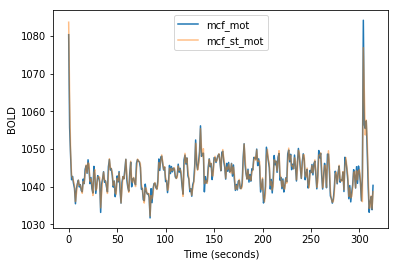

In [84]:
plt.plot(mcf_mot,label='mcf_mot') #plot the variable
plt.plot(mcf_st_mot,label='mcf_st_mot',alpha=.5)
plt.xlabel('Time (seconds)')
plt.ylabel('BOLD')
plt.legend(loc='best')

# Practice problems

### 1. What if we did slice timing correction first?

Use what you've learned above to run slice timing first followed by motion correction. It is not uncommon to see this done, so let's see what the effect is on the data by comparing the final estimate of FD with a plot.
* Name your slice-time corrected image my_bold_st.nii.gz
* Name your slice-time corrected + motion corrected image my_bold_st_mcf.nii.gz

In [86]:
%%bash

# code to do slice-timing on the raw bold



In [92]:
%%bash

# code to use fsl_motion_outliers to estimate FD on the slice-time corrected func image



In [16]:
# python code to compare FD from the raw func with FD estimated on the slice-time corrected func

In [ ]:
%%bash

# code to do motion correction on st image with mcflirt


In [ ]:
%%bash

# Plot rotations (radians) of motion on slice-time corrected functional


In [ ]:
%%bash 

# Plot translations (mm) of motion on slice-time corrected functional


In [17]:
%%bash 

# Plot displacement (mm) of motion on slice-time corrected functional

### 2. Observations

a) Was there any obvious difference on FD estimates when doing slice timing first? 


b) Based on the comparison and our discussions, which is better to run first, motion correction or slice timing?